# Project Summary: Dan Szwec

*1. I generated features from raw IMU signals, ran inference, and evaluated performance to identify significant degradation on inference data compared to test.*

*2. We started the EDA by checking the quality of the datasets, ensuring they are class balanced and have no data leakage.*

*3. We compared between the continuous features to see if there is drift in the distribution. We started to think maybe the train and test are from the same distribution but the inference is not. We also assumed that the inference data is built from two different distributions.*

*4. We compared the discrete data and saw the smoking gun: the sensor type distribution.*

*5. We separated the inference datasets by sensor type and redid the EDA cycle, confirming our assumptions.*

*6. We evaluated on those two subset inference datasets and showed that the model works perfectly on camera data but fails completely on phone data.*

***I invite you to run through my code with the detailed explanations provided in the notebook to reproduce and verify these findings.***



In [73]:
from extract_features import process_dataset
from visualization import signal_viewer
from pathlib import Path
import pandas as pd
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from typing import List

In [74]:
signal_viewer(data_dir=Path("data/raw/train"), labels_csv=Path("data/train.csv"))

***Step 2 – Generate Inference Features***

In [75]:
process_dataset("inference")

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


  0%|          | 0/473 [00:00<?, ?it/s]

100%|██████████| 473/473 [00:06<00:00, 72.57it/s] 


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,y_std,y_max,y_min,y_range,y_skew,y_kurtosis,y_n_peaks,y_energy,z_mean,z_std,z_max,z_min,z_range,z_skew,z_kurtosis,z_n_peaks,z_energy,mag_mean,mag_std,mag_max,max_delta_mag,sudden_change_score,x_fft_max,x_fft_mean,y_fft_max,y_fft_mean,z_fft_max,z_fft_mean,xy_corr,xz_corr,yz_corr,sample_id,sensor_source,timestamp,weather,driver_id,vehicle_type,speed_bin,road_type,time_of_day,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.060006,0.148782,0.274997,-0.236086,0.511083,-0.321926,-1.341806,15,2.573683,0.013797,0.155255,0.387869,-0.307613,0.695483,0.149169,-0.077644,2,2.429459,9.842721,0.044223,9.920666,9.702038,0.218627,-0.423859,-0.233783,33,9688.110464,9.845262,0.044119,9.923676,0.098246,5,9.184308,0.702095,9.208445,0.757275,984.272061,20.003247,0.197695,0.285577,-0.441790,207e6443-405d-4ee7-b7d4-1f3db8cf8152,camera,2025-05-25 14:34:56.375988,clear,D1011,sedan,fast,urban,evening,19,26,86,S750842,v1.3.0,ok,84,4.144291,4g,model_c
1,0.569179,2.811770,9.895178,-9.445290,19.340468,0.025831,2.801951,11,823.001447,-0.552887,1.929744,8.640989,-5.865182,14.506171,1.007319,4.857230,3,402.959685,9.192969,1.006973,11.742046,5.984911,5.757134,-0.012739,0.329906,34,8552.466989,9.799304,1.325866,14.999542,4.482649,6,56.917879,25.229984,55.288667,18.315723,919.296877,27.140787,-0.030401,0.090656,-0.178620,9f4fecc0-812f-4f4b-8446-efad8d742137,phone,2025-05-25 14:34:56.721310,fog,D1078,sedan,fast,rural,afternoon,11,32,55,S198872,v1.2.4,pending,86,7.355930,4g,model_a
2,0.063612,0.146808,0.310775,-0.235982,0.546757,-0.389688,-1.166831,15,2.559920,0.008098,0.149129,0.330654,-0.275483,0.606137,-0.025117,-0.279322,3,2.230501,9.831544,0.086069,9.936926,9.273112,0.663814,-3.887289,19.836702,32,9666.666519,9.833981,0.085898,9.939942,0.623247,4,8.801819,0.719598,8.738671,0.717394,983.154400,20.390584,0.244708,-0.144524,-0.268264,b2d8eb57-b999-46c4-90b8-e9ddcf21cfc5,camera,2025-05-25 14:34:56.294036,rain,D1082,truck,fast,urban,night,25,57,37,S655167,v1.2.4,recent,33,3.618941,wifi,model_c
3,-0.318921,2.113781,6.016287,-5.439766,11.456053,0.978227,1.667670,10,456.977908,-1.217374,1.538193,4.453002,-5.802365,10.255367,0.496235,2.790783,3,384.803885,11.829863,0.948647,14.110881,8.421126,5.689755,-0.609935,1.551538,31,14084.557836,12.174887,1.017609,15.208786,4.197970,7,38.749477,19.398003,121.737410,15.897383,1182.986255,31.841595,-0.017361,0.292863,-0.081187,1caa67b4-3b5e-4078-a9c3-a61b8253b1aa,phone,2025-05-25 14:34:55.966878,rain,D1019,sedan,fast,urban,night,28,24,808,S214125,v1.2.4,ok,96,6.844858,4g,model_a
4,2.045474,1.997179,7.794805,-3.443064,11.237869,0.150044,1.559010,25,817.268603,1.968928,1.533378,9.347239,-1.248262,10.595501,0.903161,4.002475,28,622.792685,10.450537,0.985188,13.202417,8.112976,5.089441,0.314803,-0.028235,32,11018.432869,11.104077,1.133322,14.011406,4.408961,7,204.547376,21.192623,196.892803,17.161034,1045.053744,29.137016,0.162387,-0.004558,-0.171916,e976280d-8161-41e9-aa37-b4f1a6652e39,phone,2025-05-25 14:34:55.893885,fog,D1077,sedan,medium,highway,night,21,41,2,S221106,v1.3.0,recent,97,6.166213,wifi,model_a
5,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,1.695301,6.482397,-7.164478,13.646875,-0.540911,6.073187,15,403.133334,9.793264,0.854602,12.054821,7.994420,4.060400,0.462240,-0.044284,37,9663.835516,10.261484,1.192682,14.557905,4.560913,6,163.601801,18.872970,107.577391,17.020440,979.326355,27.143569,-0.026207,0.040792,-0.016970,fd5548de-22c7-4a7a-9a60-a72a111cfb0d,phone,2025-05-25 14:34:55.866962,clear,D1039,truck,slow,highway,afternoon,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
6,0.633188,2.493864,7.078931,-8.175584,15.254515,-0.711871,1.374959,14,662.028654,0.909744,1.506523,5.914394,-2.904013,8.818407,0.340656,0.477945,21,309.724509,12.140129,0.846544,14.287546,9.766202,4.521345,-0.544857,0.585569,31,14809.935974,12

This will create data/inference.csv using the same logic as in train/test. Note: Unlike train.csv and test.csv, this file does not contain labels.

***Step 3 – Load Labels for Inference Set***

In [76]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

***Step 4 – Run Model Predictions***


In [77]:
df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

***Step 5.a: evaluate performance on the inference set using standard metrics (accuracy, precision, recall, F1).***


*The function `evaluate_model` computes accuracy, precision, recall, and F1 score for model predictions compared to true labels.*



In [78]:
def evaluate_model(
    preds: pd.Series, probs: pd.Series, labels: pd.Series
) -> tuple[float, float, float, float, float]:
    """
    Evaluate the model's performance using standard metrics (accuracy, precision, recall, F1).

    Args:
        preds (pd.Series): Predicted labels.
        probs (pd.Series): Probabilities of the predicted labels.
        labels (pd.Series): True labels.
    Returns:
        tuple[float, float, float, float, float]: (accuracy, precision, recall, f1_score, auc_roc)
    """

    
    labels_numeric = (labels == "normal").astype(int)
    preds_numeric = (preds == "normal").astype(int)

    # calculate accuracy
    accuracy = (preds_numeric == labels_numeric).mean()

    # calculate TP, TN, FP, FN
    TP = ((preds_numeric == 1) & (labels_numeric == 1)).sum()
    FP = ((preds_numeric == 1) & (labels_numeric == 0)).sum()
    FN = ((preds_numeric == 0) & (labels_numeric == 1)).sum()

    # calculate precision, recall, f1_score
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )

    # Calculate AUC-ROC using the probability of collision class
    # Based on the debug output, it appears LabelEncoder classes are ['collision', 'normal']
    # So probs[:, 0] contains collision probabilities
    auc_roc = roc_auc_score(labels_numeric, probs[:, 1])

    return accuracy, precision, recall, f1_score, auc_roc

    


*Made a copy of inference.csv and aligned it to the train/test format by inserting a "label" column 
and assigning values according to the sample_id order.*


In [79]:
#step 1: sort the labels by the "session_id" column to match the inference data order
labels = labels.set_index("sample_id")\
               .loc[df_inf["sample_id"]]\
               .reset_index()

#step 2: make copy of the inference data
df_inf_with_labels = df_inf.copy()

#step 3: insert the "label" column into the copy of the inference data in the same index as train data
df_train = pd.read_csv("data/train.csv")
label_col_idx = df_train.columns.get_loc("label")
df_inf_with_labels.insert(int(label_col_idx), "label", labels["label"]) 


In [8]:

#evaluate the model
(
    inference_accuracy,
    inference_precision,
    inference_recall,
    inference_f1_score,
    inference_auc_roc,
) = evaluate_model(preds, probs, labels["label"])

print(f"Inference Accuracy: {inference_accuracy}")
print(f"Inference Precision: {inference_precision}")
print(f"Inference Recall: {inference_recall}")
print(f"Inference F1 Score: {inference_f1_score}")
print(f"Inference AUC-ROC: {inference_auc_roc}")

Inference Accuracy: 0.6448202959830867
Inference Precision: 0.8876404494382022
Inference Recall: 0.3333333333333333
Inference F1 Score: 0.48466257668711654
Inference AUC-ROC: 0.7610670099406422


***Step 5.b: Compare against performance on the test set (test.csv).***


*Prepare the test dataset and generate predictions using the trained model for evaluation.*



In [10]:
# get test data and labels
df_test = pd.read_csv("data/test.csv")

test_labels = df_test["label"]

# remove label from df_test to eliminate possible leakage
df_test_no_label = df_test.drop(columns=["label"])

# make predictions
test_preds = model.predict(df_test_no_label)
test_probs = model.predict_proba(df_test_no_label)

# evaluate model performance
test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc = (
    evaluate_model(test_preds, test_probs, test_labels)
)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")
print(f"Test AUC-ROC: {test_auc_roc}")

Test Accuracy: 0.945
Test Precision: 0.9009009009009009
Test Recall: 1.0
Test F1 Score: 0.947867298578199
Test AUC-ROC: 0.92815


****Compare the performance metrics between the test set and the inference set.****


In [11]:
metrics_df: pd.DataFrame = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"],
        "Inference": [
            inference_accuracy,
            inference_precision,
            inference_recall,
            inference_f1_score,
            inference_auc_roc,
        ],
        "Test": [
            test_accuracy,
            test_precision,
            test_recall,
            test_f1_score,
            test_auc_roc,
        ],
    }
)
print(metrics_df)

      Metric  Inference      Test
0   Accuracy   0.644820  0.945000
1  Precision   0.887640  0.900901
2     Recall   0.333333  1.000000
3   F1 Score   0.484663  0.947867
4    AUC-ROC   0.761067  0.928150


*There is a significant decrease in performance on the inference data.
Let's perform exploratory data analysis (EDA) on both the test and inference sets to investigate further.*


**Step 5.c: First, let's check that all the data is valid before proceeding. by data quality check function**


In [12]:
def data_quality_check(
    dfs: List[pd.DataFrame],
    names: List[str]
) -> None:
    """
    Performs data quality checks on a list of DataFrames.

    Args:
        dfs (List[pd.DataFrame]): List of datasets to check.
        names (List[str]): List of names corresponding to each dataset.

    Returns:
        None
    """
    print("=" * 60)
    print("STEP 1: DATA QUALITY CHECK")
    print("=" * 60)

    # 1. Basic Dataset Information
    print("\nDATASET OVERVIEW:")
    datasets = dict(zip(names, dfs))
    for name, df in datasets.items():
        print(f"  {name}: {df.shape[0]} rows, {df.shape[1]} columns")

    # 2. Missing Values Analysis
    print("\nMISSING VALUES ANALYSIS:")
    all_clean = True
    for name, df in datasets.items():
        missing_count = df.isnull().sum().sum()
        if missing_count > 0:
            print(f"  {name}: {missing_count} missing values found")
            all_clean = False
        else:
            print(f"  {name}: No missing values")

    if all_clean:
        print("  All datasets are clean - no missing values!")

    if len(dfs) > 1:
        # 3. Between-Dataset Duplicate Analysis (Data Leakage Check)
        print("\nBETWEEN-DATASET DUPLICATE ANALYSIS (Data Leakage):")
        for i in range(len(dfs)):
            for j in range(i+1, len(dfs)):
                dups = len(pd.merge(dfs[i], dfs[j], how='inner'))
                print(f"  {names[i]}-{names[j]} overlap: {dups} duplicate rows")
        # 4. SESSION ID UNIQUENESS
        print("\nSESSION ID UNIQUENESS:")
        session_id_overlap = set(dfs[0]['session_id'])
        for df in dfs[1:]:
            session_id_overlap = session_id_overlap & set(df['session_id'])
        if session_id_overlap:
            print(f"  Overlapping session_id count: {len(session_id_overlap)}")
        else:
            print("  No session id overlap between datasets")

    #5. Label Distribution (for datasets with labels)
    print("\nLABEL DISTRIBUTION:")
    for name, df in datasets.items():
        if 'label' in df.columns:
            label_counts = df['label'].value_counts()
            print(f"  {name}:")
            for label, count in label_counts.items():
                pct = (count / len(df)) * 100
                print(f"    {label}: {count} ({pct:.1f}%)")
    


In [13]:
#run the function
data_set_list = [df_train, df_test, df_inf_with_labels]
data_quality_check(data_set_list, ["train", "test", "inference"])

STEP 1: DATA QUALITY CHECK

DATASET OVERVIEW:
  train: 800 rows, 61 columns
  test: 200 rows, 61 columns
  inference: 473 rows, 61 columns

MISSING VALUES ANALYSIS:
  train: No missing values
  test: No missing values
  inference: No missing values
  All datasets are clean - no missing values!

BETWEEN-DATASET DUPLICATE ANALYSIS (Data Leakage):
  train-test overlap: 0 duplicate rows
  train-inference overlap: 0 duplicate rows
  test-inference overlap: 0 duplicate rows

SESSION ID UNIQUENESS:
  No session id overlap between datasets

LABEL DISTRIBUTION:
  train:
    normal: 400 (50.0%)
    collision: 400 (50.0%)
  test:
    normal: 100 (50.0%)
    collision: 100 (50.0%)
  inference:
    normal: 237 (50.1%)
    collision: 236 (49.9%)


Data quality check passed:
- **No overlap or leakage between datasets**
- No missing values
- No duplicate rows
- Data types are consistent
- Labels are balanced


(The output above is probably truncated. To see all the checks, open it in a scrollable element or a text editor.)


-------------------------------------------------------------------------------------------------------------------

***Next, we will compare all continuous features by analyzing the distribution differences between test vs train and inference vs train datasets.***


*The compare_continuous_features function analyzes distribution differences between two datasets* *by comparing statistical properties of continuous features*
*Column Explanations:*

* **data_set maen and std** :*For every feature in each dataset, we calculate the standard* *deviation (std) and mean.*

*  **mean ratio**: *Ratio of feature mean in dataset2 to dataset1.*

* **std ratio**: *Ratio of feature std in dataset2 to dataset1.*

*  **MAE**: *Mean Absolute Error across all samples for this feature*

 *For 'Difference_Type', we primarily rely on the ratio of means to categorize the magnitude of distribution shift: 'LARGE' for |mean_ratio - 1| > 10, 'MEDIUM' for > 0.5, and 'SMALL' otherwise. We also ensure this assessment with the MAE to provide a more robust indication of significant changes.*

--------------------------------------------------------------------------------------------------

*he thresholds for LARGE, MEDIUM, and SMALL differences are chosen manually:*

*Ratios >11 or <-9 are considered order-of-magnitude changes (LARGE).*

*Ratios between 1.5-11 or -9 to -0.5 are about one and a half times bigger or smaller (MEDIUM)*

*Ratios between 0.5-1.5 are minor, likely normal, variations (SMALL).*






In [58]:
def compare_continuous_features(dataset1: pd.DataFrame, 
                                       dataset2: pd.DataFrame,
                                       datasets_names: List[str],
                                       features_list: List[str]) -> pd.DataFrame:
    """
    Compare IMU features between two datasets with enhanced metrics.
    
    Args:
        dataset1: First dataset DataFrame
        dataset2: Second dataset DataFrame  
        datasets_names: List of names for the datasets
        features_list: List of features to compare
        
    Returns:
        DataFrame with comparison metrics including mean ratios, std ratios, and MAE
    """
    
    dataset1_name = datasets_names[0]
    dataset2_name = datasets_names[1]

    print("=" * 60)
    print(f"STEP 2.1: {dataset1_name} vs {dataset2_name}")
    print("=" * 60)

    comparison_data = []

    # loop through all features in the features_list
    for feature in features_list:
        if feature in dataset1.columns and feature in dataset2.columns:
            dataset1_mean = dataset1[feature].mean()
            dataset2_mean = dataset2[feature].mean()
            dataset1_std = dataset1[feature].std()
            dataset2_std = dataset2[feature].std()
            
            # Calculate ratios
            mean_ratio = dataset2_mean / dataset1_mean if dataset1_mean != 0 else np.nan
            std_ratio = dataset2_std / dataset1_std if dataset1_std != 0 else np.nan
            
            # Calculate MAE (Mean Absolute Error)
            mae = np.mean(np.abs(dataset2[feature] - dataset1[feature]))
            
            # Determine difference type based on mean ratio
            if not np.isnan(mean_ratio):
                if abs(mean_ratio - 1) > 10:
                    diff_type = 'LARGE'
                elif abs(mean_ratio - 1) > 0.5:
                    diff_type = 'MEDIUM'
                else:
                    diff_type = 'SMALL'
            else:
                diff_type = 'N/A'
                
            # Add to comparison data
            comparison_data.append({
                'Feature': feature,
                f'{dataset1_name}_Mean': dataset1_mean,
                f'{dataset1_name}_Std': dataset1_std,
                f'{dataset2_name}_Mean': dataset2_mean,
                f'{dataset2_name}_Std': dataset2_std,
                f'Mean_Ratio ({dataset2_name}/{dataset1_name})': mean_ratio,
                f'Std_Ratio ({dataset2_name}/{dataset1_name})': std_ratio,
                f'MAE between {dataset2_name} and {dataset1_name}': mae,
                'Difference_Type': diff_type
            })
    
    # Create DataFrame and display
    comparison_df = pd.DataFrame(comparison_data)  
    
    # Sort: First by Difference_Type (LARGE > MEDIUM > SMALL), then by mean ratio within each group
    comparison_df['Difference_Type_Order'] = comparison_df['Difference_Type'].map({'LARGE': 3, 'MEDIUM': 2, 'SMALL': 1, 'N/A': 0})
    comparison_df = comparison_df.sort_values(['Difference_Type_Order', f'Mean_Ratio ({dataset2_name}/{dataset1_name})'], ascending=[False, False])
    comparison_df = comparison_df.drop('Difference_Type_Order', axis=1)
    
    # Format the display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    return comparison_df

In [59]:
#all continuous features
continuous_features_list = [
        # IMU (Accelerometer) - X axis
        'x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis', 'x_n_peaks', 'x_energy',
        # IMU (Accelerometer) - Y axis
        'y_mean', 'y_std', 'y_max', 'y_min', 'y_range', 'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy',
        # IMU (Accelerometer) - Z axis
        'z_mean', 'z_std', 'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks', 'z_energy',
        # Magnetometer
        'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag', 'sudden_change_score',
        # FFT (Frequency Domain)
        'x_fft_max', 'x_fft_mean', 'y_fft_max', 'y_fft_mean', 'z_fft_max', 'z_fft_mean',
        # Correlation
        'xy_corr', 'xz_corr', 'yz_corr',
        # Environmental
        'temperature', 'humidity', 'altitude',
        # Device (numerical parts)
        'battery_level', 'gps_accuracy'
    ]
 
compare_continuous_features(df_train, df_test, ["train", "test"], continuous_features_list) 

STEP 2.1: train vs test


,Feature,train_Mean,train_Std,test_Mean,test_Std,Mean_Ratio (test/train),Std_Ratio (test/train),MAE between test and train,Difference_Type
5,x_skew,0.303161,1.374389,0.559799,1.596366,1.846545,1.161509,1.241928,MEDIUM
6,x_kurtosis,1.937158,6.623564,3.202769,7.764374,1.653334,1.172235,5.957248,MEDIUM
2,x_max,0.556487,0.559195,0.664455,0.658683,1.194019,1.177912,0.506413,SMALL
4,x_range,0.776821,0.559766,0.884504,0.661643,1.138620,1.181999,0.513428,SMALL
8,x_energy,3.483957,2.179326,3.955851,2.676421,1.135448,1.228095,1.994007,SMALL
33,x_fft_mean,0.982066,0.570111,1.092364,0.672068,1.112312,1.178836,0.520804,SMALL
1,x_std,0.166067,0.046038,0.175786,0.055861,1.058526,1.213357,0.042920,SMALL
38,xy_corr,0.206850,0.149052,0.214421,0.161617,1.036597,1.084302,0.135634,SMALL
0,x_mean,0.069947,0.015884,0.072357,0.017860,1.034463,1.124368,0.015130,SMALL
31,sudden_change_score,3.926250,1.503708,4.050000,1.552272,1.031519,1.032296,1.855000,SMALL


*As indicated in the "Difference_Type" column, all features show either small or medium differences, with no large discrepancies detected. This is true for both the mean, std ratio, and MAE columns, suggesting that the test set is well-aligned with the training data and does not exhibit significant data drift.*


---------------------------------------------------------------------------------------------------------

*Let's compare the inference data on the continuous features.*


In [60]:
compare_continuous_features(df_train, df_inf_with_labels, ["train", "inference"], continuous_features_list) 

STEP 2.1: train vs inference


,Feature,train_Mean,train_Std,inference_Mean,inference_Std,Mean_Ratio (inference/train),Std_Ratio (inference/train),MAE between inference and train,Difference_Type
8,x_energy,3.483957,2.179326,403.629173,352.366176,115.853659,161.685823,400.779198,LARGE
17,y_energy,2.727654,0.831120,287.908905,291.278571,105.551826,350.464980,285.424455,LARGE
9,y_mean,0.022268,0.012597,0.482968,0.982501,21.689042,77.994758,0.719717,LARGE
3,x_min,-0.220334,0.018115,-4.531746,3.743591,20.567582,206.657590,4.317199,LARGE
33,x_fft_mean,0.982066,0.570111,13.967131,9.928472,14.222196,17.414971,13.159106,LARGE
28,mag_std,0.053824,0.023181,0.724117,0.509163,13.453378,21.964599,0.677432,LARGE
30,max_delta_mag,0.248225,0.243842,3.291816,2.488991,13.261423,10.207411,3.118522,LARGE
4,x_range,0.776821,0.559766,9.869767,7.180939,12.705331,12.828462,9.266058,LARGE
35,y_fft_mean,0.922535,0.337759,10.787327,7.564381,11.693139,22.395773,9.983218,LARGE
19,z_std,0.054150,0.025974,0.599894,0.404251,11.078377,15.563762,0.553509,LARGE


**The output shows a dramatic data drift between train and inference datasets, with energy features (x_energy, y_energy) showing large differences (115x and 105x ratios respectively) and very high MAE values, indicating the inference data has much higher sensor energy values than the training data.**



 **Most IMU features (accelerometer x/y, FFT features, magnetic field data) show medium to large differences between datasets, while environmental features (temperature, humidity, battery) remain relatively stable. Additionally, the standard deviation ratio indicates that the inference dataset has much higher variability, highlighting potential clusters in the data.**




-----------------------------------------------------------------------------------------------------

*For visualization, I run PCA on the three datasets to check if our assumptions align with the actual data distributions.*


In [69]:
def visualize_pca_comparison(datasets_list: List[pd.DataFrame], 
                           datasets_names: List[str],
                           features_list: List[str],
                           ) -> None:
    """
    Visualize datasets using PCA to show distribution differences.
    
    Args:
        datasets_list: List of datasets to compare
        datasets_names: Names of the datasets
        features_list: Features to use for PCA
    """
    
    # Prepare data for PCA
    all_data = []
    all_labels = []
    
    for i, dataset in enumerate(datasets_list):
        # Select only the features that exist in the dataset
        available_features = [f for f in features_list if f in dataset.columns]
        if available_features:
            data_subset = dataset[available_features].fillna(0)  # Handle any missing values
            all_data.append(data_subset)
            all_labels.extend([datasets_names[i]] * len(data_subset))
    
    if not all_data:
        print("No valid features found for PCA analysis")
        return
    
    # Combine all datasets
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)
    
    # Apply PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create DataFrame for plotting
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(3)])
    pca_df['Dataset'] = all_labels
    
    
    # 3D Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, dataset_name in enumerate(datasets_names):
        if dataset_name in pca_df['Dataset'].values:
            mask = pca_df['Dataset'] == dataset_name
            ax.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], pca_df[mask]['PC3'],
                        label=dataset_name, alpha=0.6, s=30, c=colors[i % len(colors)])
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA Comparison of Datasets')
    ax.legend()
    plt.tight_layout()
    

*Run PCA visualization on the three datasets: train, test, and inference_with_labels*



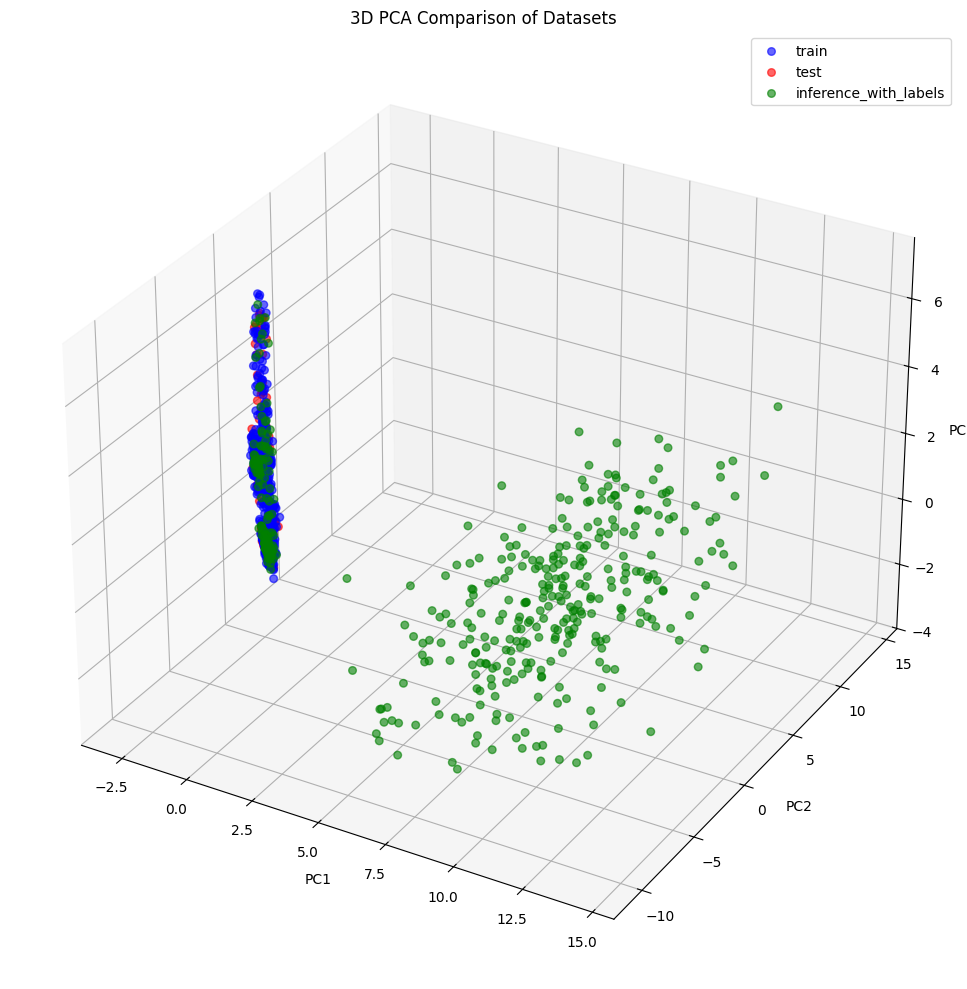

In [70]:
data_sets_list = [df_train, df_test, df_inf_with_labels]
datasets_names = ['train', 'test', 'inference_with_labels']

visualize_pca_comparison(data_sets_list, datasets_names, continuous_features_list)


**This visualization confirms that the inference data distribution is not aligned with train/test data and may contain multiple underlying distributions, explaining the model's performance degradation.**

--------------------------------------------------------------------------------------------------------------

*now we want to compares categorical features across train/test/inference datasets to identify data drift by creating bar chart visualizations and calculating percentage differences between all three datasets.*

In [61]:
def visualize_discrete_features(datasets_list: List[pd.DataFrame],
                               datasets_names: List[str],
                               features_list: List[str] = None) -> None:
    """
    Visualize discrete features across train, test, and inference datasets.
    
    Args:
        datasets_list: List of datasets
        datasets_names: List of dataset names
        features_list: List of discrete features to visualize
    """
    
    dataset1_df = datasets_list[0]
    dataset2_df = datasets_list[1]
    dataset3_df = datasets_list[2]

    
    # Filter to only features that exist in the data
    available_features = [f for f in features_list if f in dataset1_df.columns]
    
    # Calculate number of subplots needed
    n_features = len(available_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    for idx, feature in enumerate(available_features):
        ax = axes_flat[idx]
        
        # Get value counts for each dataset
        train_counts = dataset1_df[feature].value_counts(normalize=True) * 100
        test_counts = dataset2_df[feature].value_counts(normalize=True) * 100
        inference_counts = dataset3_df[feature].value_counts(normalize=True) * 100
        
        # Get all unique values across all datasets
        all_values = set(train_counts.index) | set(test_counts.index) | set(inference_counts.index)
        
        # Create comparison data
        comparison_data = []
        for value in sorted(all_values):
            train_pct = train_counts.get(value, 0)
            test_pct = test_counts.get(value, 0)
            inference_pct = inference_counts.get(value, 0)
            comparison_data.append([value, train_pct, test_pct, inference_pct])
        
        # Create DataFrame for plotting
        plot_df = pd.DataFrame(comparison_data, 
                              columns=['Value', f'{datasets_names[0]} (%)', f'{datasets_names[1]} (%)', f'{datasets_names[2]} (%)'])
        
        # Plot
        x = range(len(plot_df))
        width = 0.25
        
        ax.bar([i - width for i in x], plot_df[f'{datasets_names[0]} (%)'], width, label=datasets_names[0], alpha=0.8)
        ax.bar(x, plot_df[f'{datasets_names[1]} (%)'], width, label=datasets_names[1], alpha=0.8)
        ax.bar([i + width for i in x], plot_df[f'{datasets_names[2]} (%)'], width, label=datasets_names[2], alpha=0.8)
        
        ax.set_xlabel('Values')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'{feature} Distribution')
        ax.set_xticks(x)
        ax.set_xticklabels(plot_df['Value'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(available_features), len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout()
    

def compare_discrete_features(datasets_list: List[pd.DataFrame],
                              datasets_names: List[str],
                              features_list: List[str]):
    """
    Compare discrete features across train, test, and inference datasets.
    """

    dataset1_df = datasets_list[0]
    dataset2_df = datasets_list[1]
    dataset3_df = datasets_list[2]
    
    # Create summary DataFrame
    print("=" * 80)
    print("DISCRETE FEATURES COMPARISON DATAFRAME")
    print("=" * 80)
    
    all_comparisons = []
    
    for feature in features_list:
        train_counts = dataset1_df[feature].value_counts(normalize=True) * 100
        test_counts = dataset2_df[feature].value_counts(normalize=True) * 100
        inference_counts = dataset3_df[feature].value_counts(normalize=True) * 100
        
        all_values = set(train_counts.index) | set(test_counts.index) | set(inference_counts.index)
        
        for value in sorted(all_values):
            train_pct = train_counts.get(value, 0)
            test_pct = test_counts.get(value, 0)
            inference_pct = inference_counts.get(value, 0)
            
            # Calculate differences
            train_test_diff = abs(train_pct - test_pct)
            train_inf_diff = abs(train_pct - inference_pct)
            
            # Determine difference type based on train-inference (most important)
            if train_inf_diff > 10:
                diff_type = "LARGE"
            elif train_inf_diff > 5:
                diff_type = "MEDIUM"
            else:
                diff_type = "SMALL"
            
            all_comparisons.append({
                'Feature': feature,
                'Value': value,
                f'{datasets_names[0]} (%)': round(train_pct, 1),
                f'{datasets_names[1]} (%)': round(test_pct, 1),
                f'{datasets_names[2]} (%)': round(inference_pct, 1),
                f'{datasets_names[0]}_{datasets_names[1]}_Diff (%)': round(train_test_diff, 1),
                f'{datasets_names[0]}_{datasets_names[2]}_Diff (%)': round(train_inf_diff, 1),
                'Difference_Type': diff_type
            })
    
    # Create DataFrame and sort
    comparison_df = pd.DataFrame(all_comparisons)
    
    # Sort by difference type and then by train-inference difference
    diff_type_order = {'LARGE': 3, 'MEDIUM': 2, 'SMALL': 1}
    comparison_df['Difference_Type_Order'] = comparison_df['Difference_Type'].map(diff_type_order)
    comparison_df = comparison_df.sort_values(['Difference_Type_Order', f'{datasets_names[0]}_{datasets_names[2]}_Diff (%)'], ascending=[False, False])
    comparison_df = comparison_df.drop('Difference_Type_Order', axis=1)
    
    # Display DataFrame
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    return comparison_df
    


DISCRETE FEATURES COMPARISON DATAFRAME


,Feature,Value,train (%),test (%),inference (%),train_test_Diff (%),train_inference_Diff (%),Difference_Type
0,sensor_source,camera,100.0,100.0,34.7,0.0,65.3,LARGE
1,sensor_source,phone,0.0,0.0,65.3,0.0,65.3,LARGE
4,weather,rain,31.4,35.0,36.4,3.6,5.0,SMALL
25,network_type,5g,32.1,32.5,36.6,0.4,4.5,SMALL
5,vehicle_type,sedan,31.5,28.5,35.3,3.0,3.8,SMALL
23,calibration_status,recent,32.4,36.0,28.5,3.6,3.8,SMALL
3,weather,fog,36.5,34.5,33.4,2.0,3.1,SMALL
18,firmware_version,v1.2.3,33.5,27.0,30.4,6.5,3.1,SMALL
10,speed_bin,slow,32.1,34.5,35.1,2.4,3.0,SMALL
7,vehicle_type,truck,36.8,36.0,33.8,0.8,2.9,SMALL


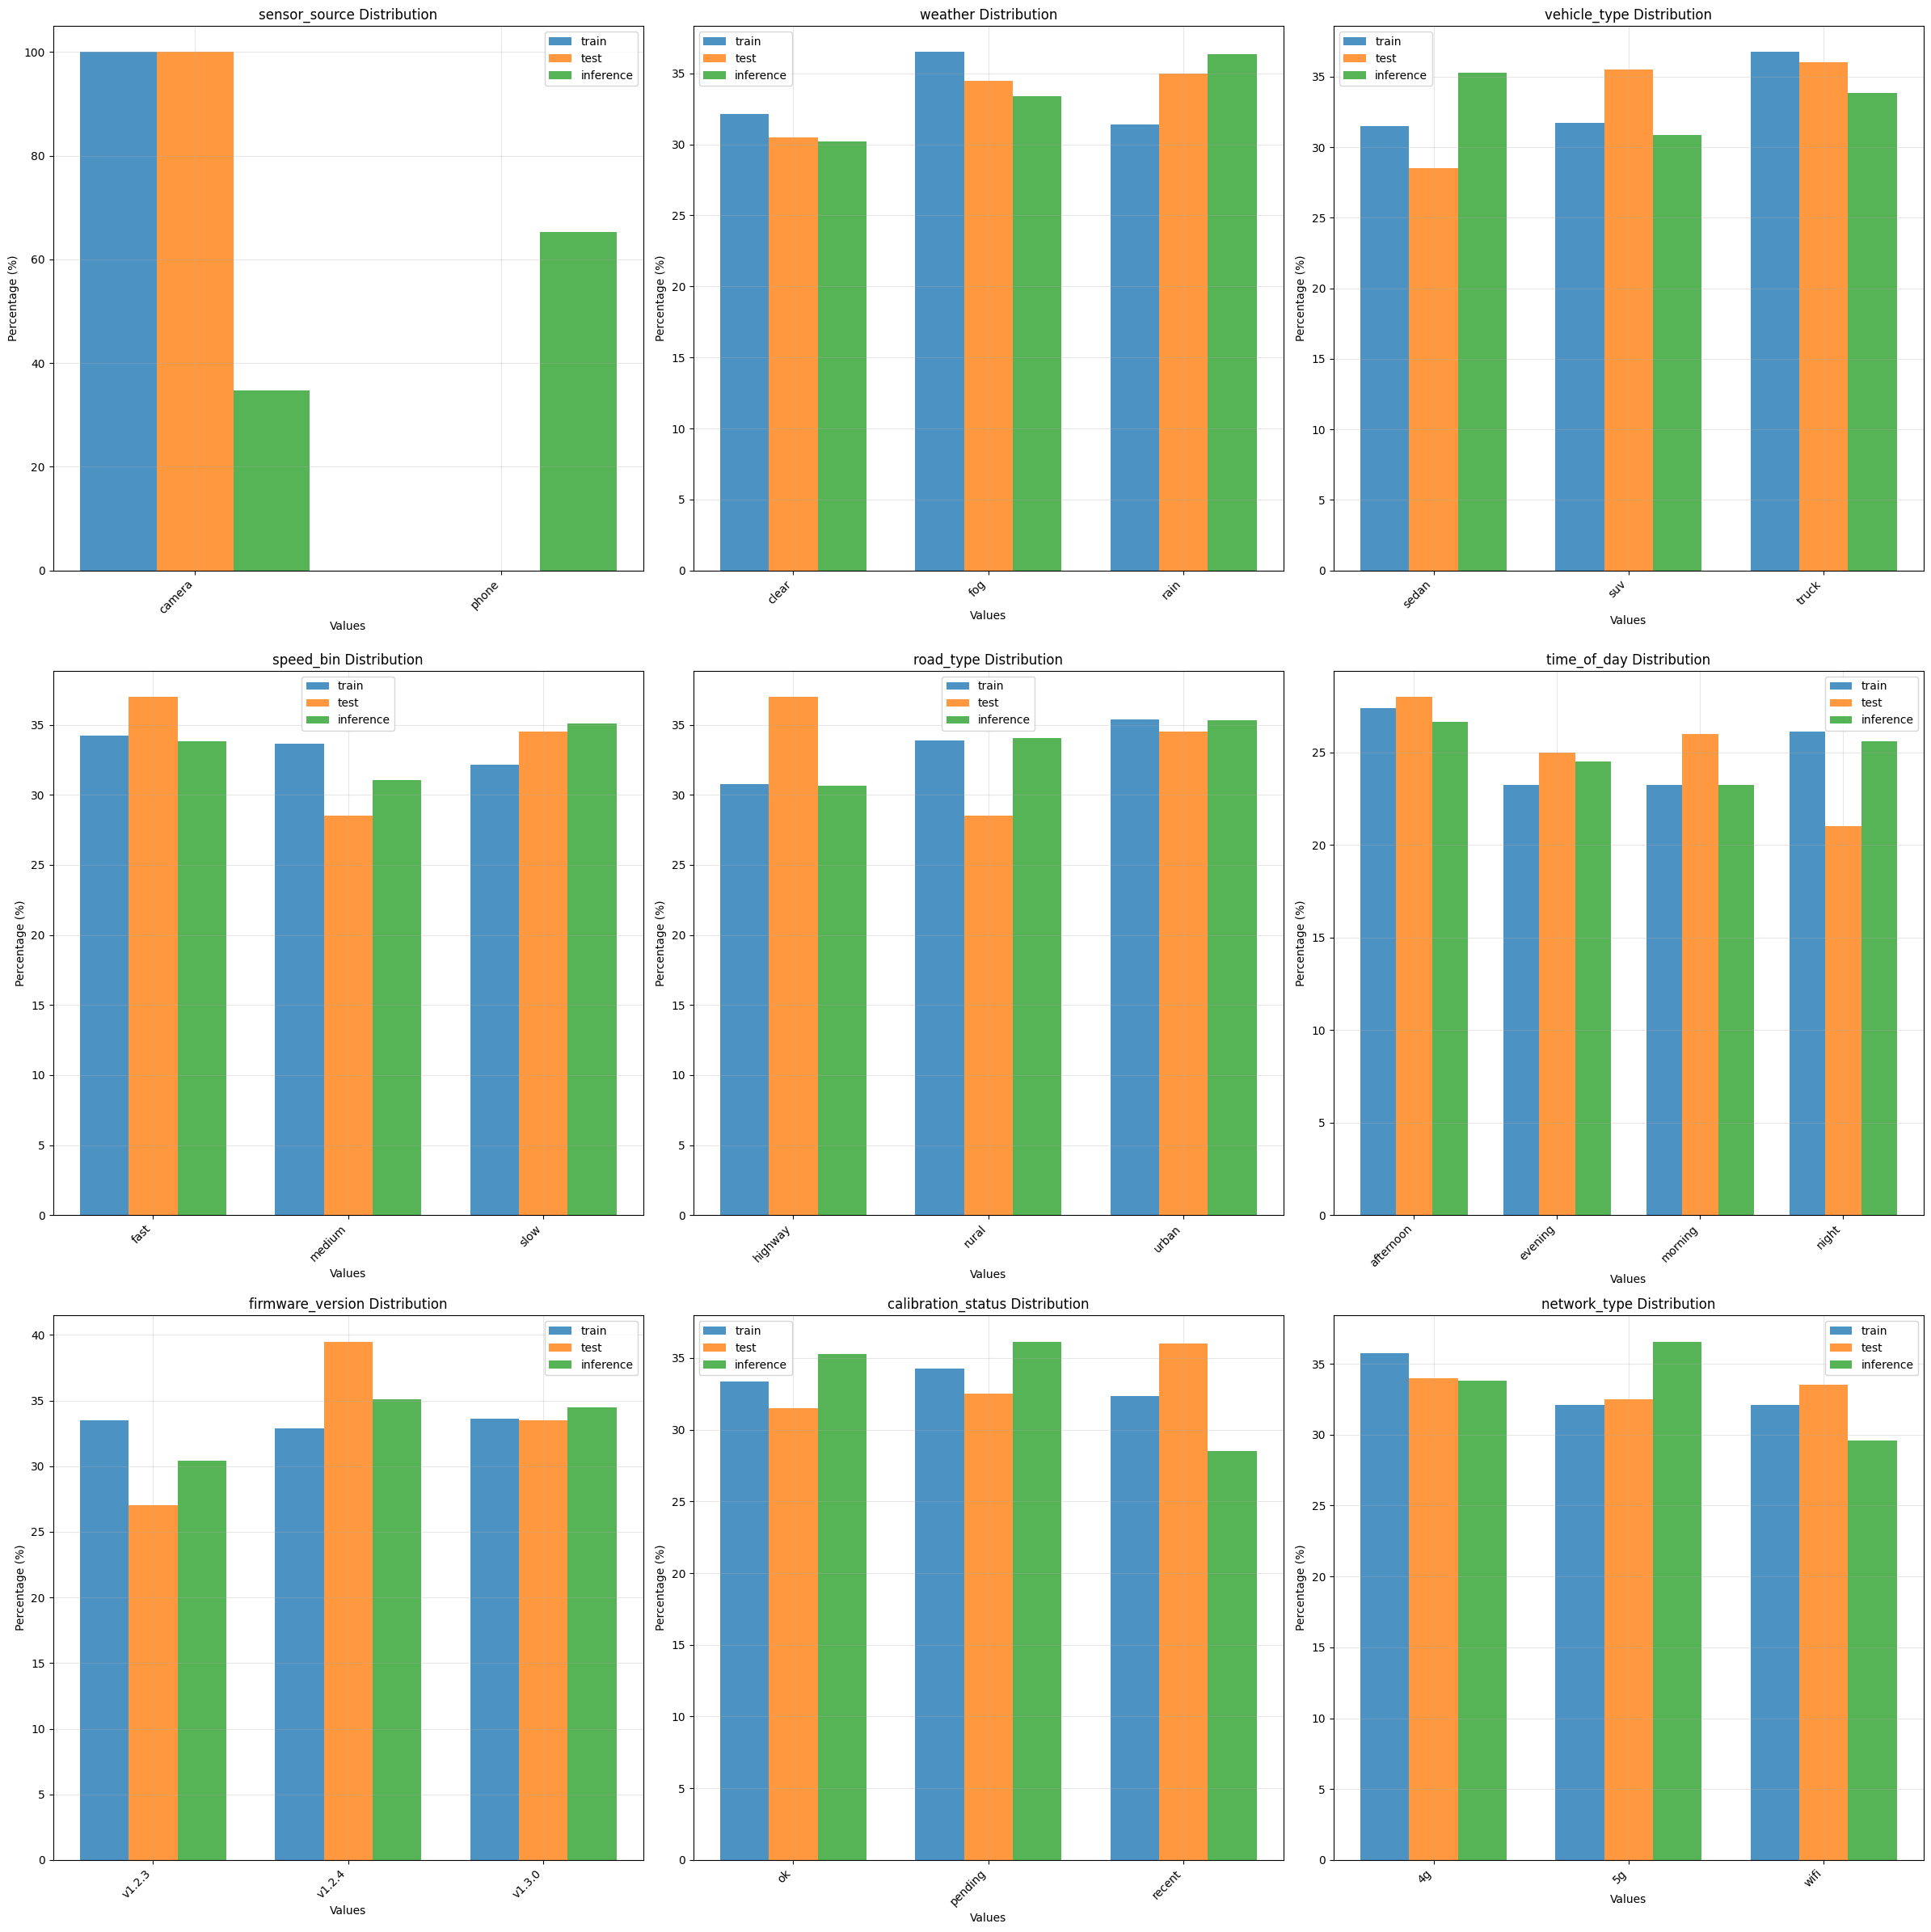

In [37]:
# Get all features except continuous features 
discrete_features_list = ['sensor_source', 'weather', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day', 'firmware_version', 'calibration_status', 'network_type']

#run the function
datasets_list = [df_train, df_test, df_inf_with_labels]
datasets_names = ['train', 'test', 'inference']

#visualize the discrete features    
visualize_discrete_features(datasets_list, datasets_names, discrete_features_list) 

#compare the discrete features
compare_discrete_features(datasets_list, datasets_names, discrete_features_list) 


**The discrete features analysis reveals that "sensor_source" shows the most dramatic data drift with train/test datasets being 100% camera data while inference contains 65% phone and 35% camera data, creating a 65% difference.**

*All other discrete features (weather, vehicle_type, speed_bin, road_type, time_of_day, firmware_version, calibration_status, network_type) show only small to medium differences (0-6.6%) between train and inference datasets, indicating they are unlikely to be the primary cause of the model's performance degradation.*

---------------------------------------------------------------------------------------------------

**Now we separate the inference dataset into camera and phone subsets for further analysis.**


*Before evaluation, we will perform EDA on each subset to better understand their characteristics.*


In [25]:
# Separate inference data by sensor_source
df_inf_camera = df_inf_with_labels[df_inf_with_labels['sensor_source'] == 'camera'].copy()
df_inf_phone = df_inf_with_labels[df_inf_with_labels['sensor_source'] == 'phone'].copy()

*lets check that everything is valid*



In [26]:
data_set_list = [df_inf_camera, df_inf_phone]
data_quality_check(data_set_list, ["inference_camera", "inference_phone"])

STEP 1: DATA QUALITY CHECK

DATASET OVERVIEW:
  inference_camera: 164 rows, 61 columns
  inference_phone: 309 rows, 61 columns

MISSING VALUES ANALYSIS:
  inference_camera: No missing values
  inference_phone: No missing values
  All datasets are clean - no missing values!

BETWEEN-DATASET DUPLICATE ANALYSIS (Data Leakage):
  inference_camera-inference_phone overlap: 0 duplicate rows

SESSION ID UNIQUENESS:
  No session id overlap between datasets

LABEL DISTRIBUTION:
  inference_camera:
    collision: 85 (51.8%)
    normal: 79 (48.2%)
  inference_phone:
    normal: 158 (51.1%)
    collision: 151 (48.9%)


*Everything is valid. Each inference subset is also balanced by label.*


----------------------------------------------------------------------------------------------------------

*Now we compare continuous values between the train set and each of the inference subsets (camera and phone).*


*Start with the phone subset*


In [62]:
compare_continuous_features(df_train,  df_inf_phone, ['train', 'inference_phone'], continuous_features_list) 

STEP 2.1: train vs inference_phone


,Feature,train_Mean,train_Std,inference_phone_Mean,inference_phone_Std,Mean_Ratio (inference_phone/train),Std_Ratio (inference_phone/train),MAE between inference_phone and train,Difference_Type
8,x_energy,3.483957,2.179326,615.904876,244.717231,176.783142,112.290310,612.413351,LARGE
17,y_energy,2.727654,0.831120,439.306816,252.380819,161.056625,303.663391,436.568556,LARGE
9,y_mean,0.022268,0.012597,0.728216,1.142455,32.702571,90.692542,1.095093,LARGE
3,x_min,-0.220334,0.018115,-6.819380,2.516737,30.950141,138.931549,6.598097,LARGE
33,x_fft_mean,0.982066,0.570111,20.839018,3.771681,21.219575,6.615693,19.860847,LARGE
28,mag_std,0.053824,0.023181,1.079060,0.180158,20.047867,7.771794,1.024895,LARGE
30,max_delta_mag,0.248225,0.243842,4.897281,1.415324,19.729208,5.804276,4.646531,LARGE
4,x_range,0.776821,0.559766,14.676439,3.461562,18.892949,6.183943,13.905380,LARGE
35,y_fft_mean,0.922535,0.337759,16.043596,2.774170,17.390777,8.213451,15.126052,LARGE
19,z_std,0.054150,0.025974,0.888513,0.094977,16.408365,3.656651,0.834060,LARGE


**As expected, we observe a substantial difference between the train set and the inference_phone subset.**

*Many continuous features show bigger shifts in their distributions than before, with some statistics (such as means and ranges)*
*differing by orders of magnitude.*

*This suggests that the inference_phone data is drawn from a distribution*
*that is quite distinct from the training data, which could have a significant impact on model performance.*
*Such distributional shifts are important to identify, as they may explain unexpected model behavior or degraded* *accuracy.*



---------------------------------------------------------------------------------------------------------------------


*Now we will check the camera subset*

*We expect the distribution of the camera subset to be more similar to the train set.*

*This may be because both the train set and the camera subset contain 100% camera sensor data.*



In [63]:
compare_continuous_features(df_train,  df_inf_camera, ['train', 'inference_camera'], continuous_features_list) 

STEP 2.1: train vs inference_camera


,Feature,train_Mean,train_Std,inference_camera_Mean,inference_camera_Std,Mean_Ratio (inference_camera/train),Std_Ratio (inference_camera/train),MAE between inference_camera and train,Difference_Type
24,z_kurtosis,5.164430,10.652286,6.410280,11.398979,1.241237,1.070097,10.151034,SMALL
23,z_skew,-1.085238,1.783236,-1.298658,1.908780,1.196657,1.070402,1.779938,SMALL
5,x_skew,0.303161,1.374389,0.360558,1.424637,1.189330,1.036560,1.257379,SMALL
6,x_kurtosis,1.937158,6.623564,2.198908,6.720241,1.135121,1.014596,5.965293,SMALL
30,max_delta_mag,0.248225,0.243842,0.266884,0.247939,1.075169,1.016803,0.239530,SMALL
22,z_range,0.331206,0.263020,0.353810,0.272446,1.068246,1.035839,0.249992,SMALL
2,x_max,0.556487,0.559195,0.591789,0.596330,1.063438,1.066407,0.516671,SMALL
8,x_energy,3.483957,2.179326,3.670683,2.455493,1.053596,1.126721,2.029484,SMALL
4,x_range,0.776821,0.559766,0.813296,0.597145,1.046954,1.066775,0.524897,SMALL
45,gps_accuracy,5.320635,2.603883,5.569026,2.682473,1.046684,1.030182,2.956013,SMALL


*In the camera subset of the inference data, we observe that there are no major differences compared to the train* *set.*


*Most continuous features have similar distributions, and the statistics (such as means and standard deviations)* *are closely aligned.*


**This suggests that the inference_camera data is drawn from a distribution that is consistent with the training data,**


*indicating minimal distributional shift for this subset.*

---------------------------------------------------------------------------------------------------------------------


*Let's do a PCA comparison to visually check if our assumption of two distinct distributions (camera vs phone) holds*
*and see if the inference camera distribution aligns with the training data.*




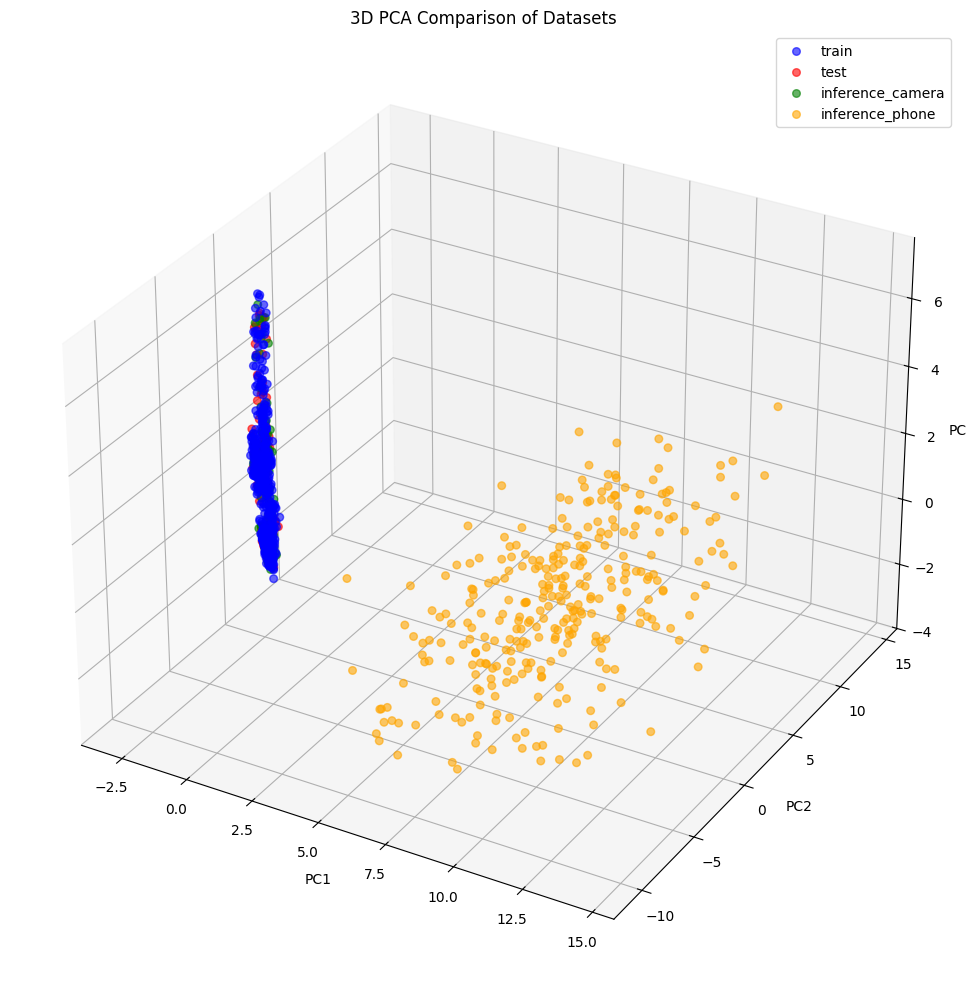

In [72]:
datasets_list_phone_camera = [df_train, df_test, df_inf_camera, df_inf_phone]
datasets_names_phone_camera = ['train', 'test', 'inference_camera', 'inference_phone']

visualize_pca_comparison(datasets_list_phone_camera, datasets_names_phone_camera, continuous_features_list)

***The 3D PCA visualization definitively validates our hypothesis by revealing the true nature of the inference data distribution.***

***The train, test, and inference_camera datasets all cluster closely together, showing they have similar distributions and that the model was trained only on camera data.***

***In contrast, the inference_phone dataset is completely separate and much more spread out.***


-----------------------------------------------------------------------------------------------------

*Let's check that the discrete feature values in train, inference_camera, and inference_phone are pretty* *similar,*

*just to make sure any differences we see aren't because of these variables.*

*By examining the distributions of discrete feature values across the train, inference_camera, and inference_phone datasets,*

*we can ensure our assumption that these variables are similarly distributed holds true.*

*This step helps confirm that any observed differences in model performance or feature statistics are not simply due to*

*changes in the distribution of discrete variables, but rather reflect genuine distributional shifts in the data.*





DISCRETE FEATURES COMPARISON DATAFRAME


,Feature,Value,train (%),inference_camera (%),inference_phone (%),train_inference_camera_Diff (%),train_inference_phone_Diff (%),Difference_Type
0,sensor_source,camera,100.0,100.0,0.0,0.0,100.0,LARGE
1,sensor_source,phone,0.0,0.0,100.0,0.0,100.0,LARGE
25,network_type,5g,32.1,31.1,39.5,1.0,7.4,MEDIUM
4,weather,rain,31.4,34.1,37.5,2.8,6.2,MEDIUM
23,calibration_status,recent,32.4,31.1,27.2,1.3,5.2,MEDIUM
3,weather,fog,36.5,37.2,31.4,0.7,5.1,MEDIUM
24,network_type,4g,35.8,39.6,30.7,3.9,5.0,MEDIUM
5,vehicle_type,sedan,31.5,35.4,35.3,3.9,3.8,SMALL
22,calibration_status,pending,34.2,33.5,37.5,0.7,3.3,SMALL
14,time_of_day,afternoon,27.4,20.7,29.8,6.6,2.4,SMALL


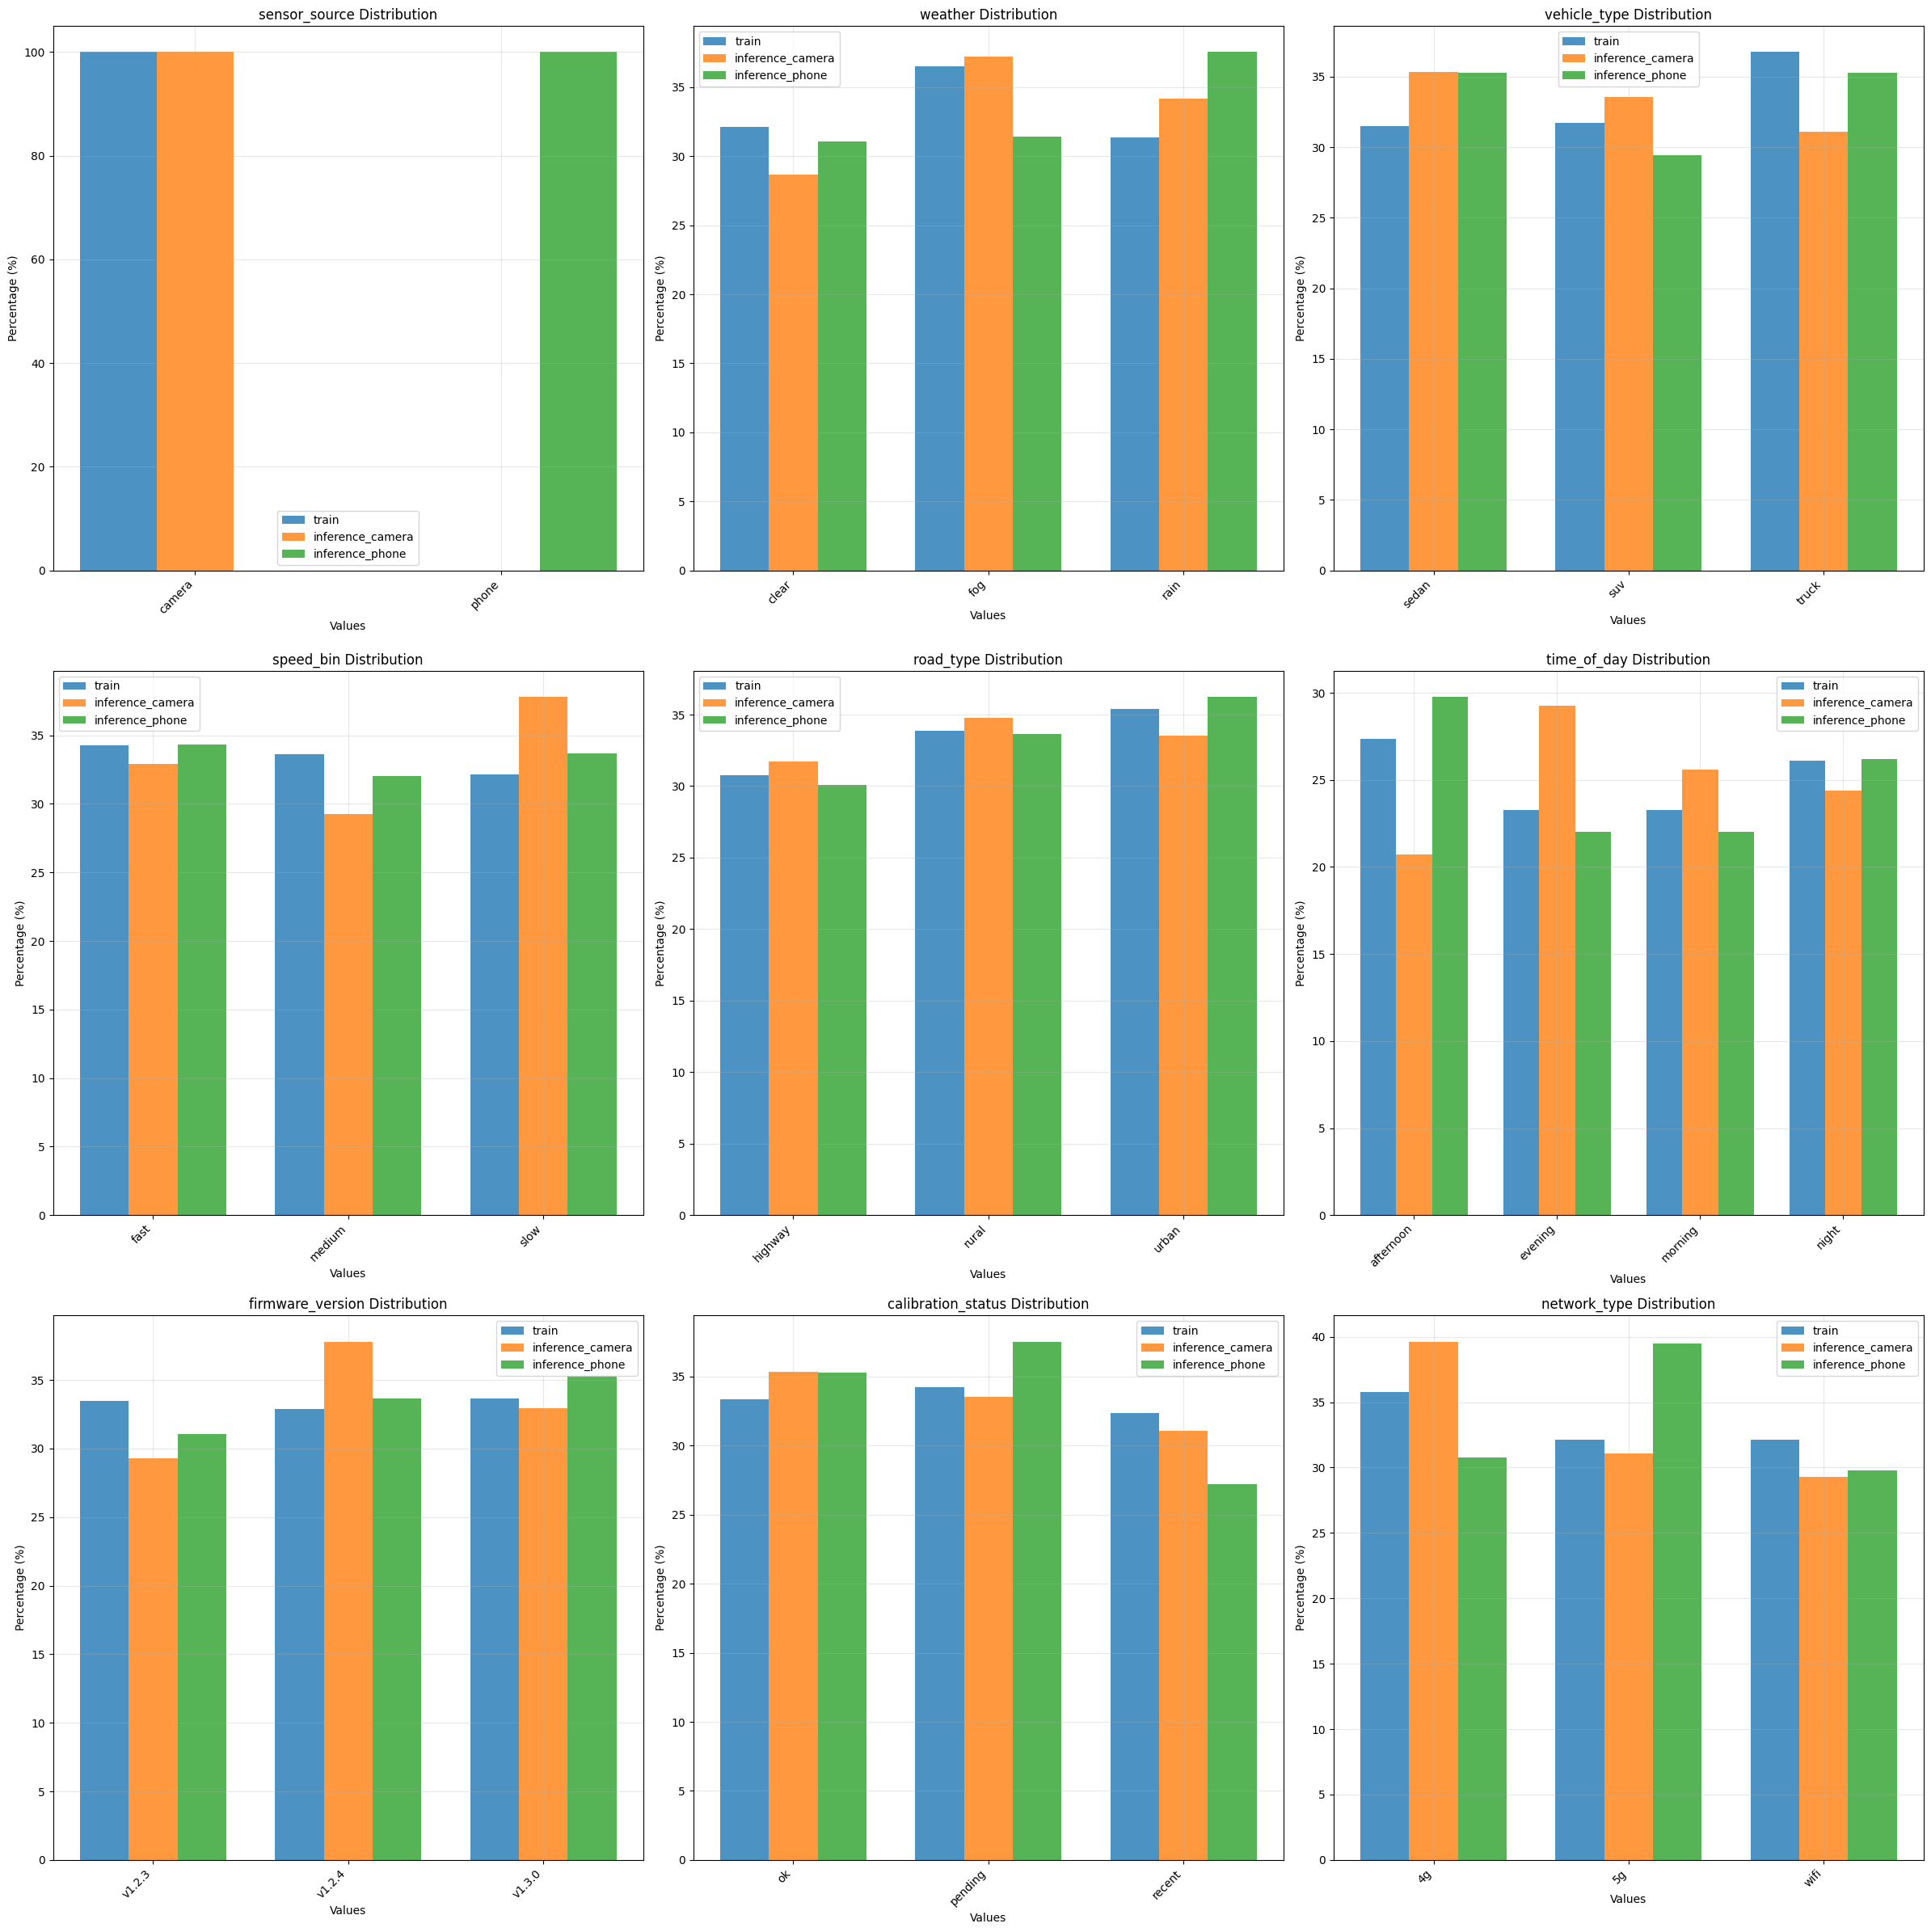

In [64]:
#run the function
datasets_list = [df_train, df_inf_camera, df_inf_phone]
datasets_names = ['train', 'inference_camera', 'inference_phone']

#visualize the discrete features    
visualize_discrete_features(datasets_list, datasets_names, discrete_features_list) 

#compare the discrete features
compare_discrete_features(datasets_list, datasets_names, discrete_features_list) 

*As expected, the camera subset contains only 'camera' entries, and the phone* *subset contains only 'phone' entries.*

**The distributions of the other discrete feature values are very similar across the train, inference_camera, and inference_phone datasets, indicating consistent proportions for these variables.**

----------------------------------------------------------------------------------


**Some fields, such as weather, calibration_status, and network_type, show small differences between datasets (e.g., network type shows a 7.
4% difference, likely due to sensor type). These differences are minor for the current task but could be worth investigating in future work.**


----------------------------------------------------------------------------------

**Now, let's evaluate each subset to check if our assumptions align.**






In [65]:
# Now, let's evaluate the model's performance on the phone inference subset.
inf_phone_labels = df_inf_phone["label"]

# remove label from df_test to eliminate possible leakage
df_inf_phone_no_label = df_inf_phone.drop(columns=["label"])

# make predictions
inf_phone_preds = model.predict(df_inf_phone_no_label)
inf_phone_probs = model.predict_proba(df_inf_phone_no_label)

# evaluate model performance
inf_phone_accuracy, inf_phone_precision, inf_phone_recall, inf_phone_f1_score, inf_phone_auc_roc = (
    evaluate_model(inf_phone_preds, inf_phone_probs, inf_phone_labels)
)

# Now, let's evaluate the model's performance on the camera inference subset.
inf_camera_labels = df_inf_camera["label"]

# remove label from df_inf_camera to eliminate possible leakage
df_inf_camera_no_label = df_inf_camera.drop(columns=["label"])

# make predictions
inf_camera_preds = model.predict(df_inf_camera_no_label)
inf_camera_probs = model.predict_proba(df_inf_camera_no_label)

# evaluate model performance
inf_camera_accuracy, inf_camera_precision, inf_camera_recall, inf_camera_f1_score, inf_camera_auc_roc = (
    evaluate_model(inf_camera_preds, inf_camera_probs, inf_camera_labels)
)




In [67]:
metrics_df: pd.DataFrame = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"],
        "Inference Phone": [
            inf_phone_accuracy,
            inf_phone_precision,
            inf_phone_recall,
            inf_phone_f1_score,
            inf_phone_auc_roc,
        ],
        "Inference Camera": [
            inf_camera_accuracy,
            inf_camera_precision,
            inf_camera_recall,
            inf_camera_f1_score,
            inf_camera_auc_roc,
        ],
        "Test": [
            test_accuracy,
            test_precision,
            test_recall,
            test_f1_score,
            test_auc_roc,
        ],
    }
)
print(metrics_df)


      Metric  Inference Phone  Inference Camera      Test
0   Accuracy         0.488673          0.939024  0.945000
1  Precision         0.000000          0.887640  0.900901
2     Recall         0.000000          1.000000  1.000000
3   F1 Score         0.000000          0.940476  0.947867
4    AUC-ROC         0.550738          0.920923  0.928150



**The inference phone dataset shows complete model failure (0% precision/recall) while the inference camera dataset performs well, confirming the model was trained only on camera data and cannot handle phone sensors. This validates our earlier finding of extreme data drift between camera and phone IMU features, demonstrating the model's lack of cross-device generalization capability.**

#  ❓ Questions to Reflect On


What do you observe when comparing the model’s predictions on the new data to its known performance?

Is there anything in the data that might explain differences in behavior?

Can you identify patterns or trends related to when the model succeeds or fails?

Are there signals or features that seem to affect the model’s reliability?

What could be done in the short term to handle the current situation?

What are potential long-term steps to improve model performance in similar scenarios?

What would you want to explore further if given more time or data?

What assumptions did the model rely on during training — and are they still valid?

# Answers


1. ***What do you observe when comparing the model’s predictions on the new data to its known  performance?***

    The model does much worse on the inference data than on the test set. Accuracy drops from 94.5% to 64.5%, mainly because recall collapses from 100% to 33% - it misses most normal events. 

    Precision stays about the same (around 89%), so when it predicts “normal” it’s usually right. But overall performance takes a hit.




2. ***Is there anything in the data that might explain differences in behavior?***

    *Yes.*

    *A likely explanation is a data mismatch: the model was trained solely on camera sensors, whereas approximately 65% of the inference set comes from phone sensors. Phone samples exhibit much higher signal values and differ significantly from the training data distribution.*

    *When evaluated separately, the model maintains strong performance on camera data but performs poorly on phone data, likely indicating that phone and camera samples originate from different underlying distributions*



3. ***Can you identify patterns or trends related to when the model succeeds or fails?***

    *The patterns are extremely clear and consistent: the model succeeds consistently on camera sensors (93.9% accuracy) across all features and samples, while failing completely on phone sensors (48.9% accuracy, 0% precision/recall) regardless of individual sample characteristics.*

    *This creates a perfect binary pattern where every camera sample succeeds and every phone sample fails, with no mixed results or feature-specific failures.*

    *The model's success/failure is 100% sensor-dependent, confirming that it was trained exclusively on camera data and cannot generalize to phone sensors, creating a systematic failure pattern based on sensor type rather than random variation or specific sample problems.*


4. ***Are there signals or features that seem to affect the model’s reliability?***
 
    *Yes, the sensor type feature significantly affects the model's reliability. The model succeeds consistently on camera sensors but fails completely on phone sensors across all IMU features.* 

    *This indicates that sensor type is the primary determinant of model reliability, as it affects all IMU features - energy, FFT, magnetic, and accelerometer features all work perfectly within their respective sensor domains but fail when applied to different sensor types.*

    *The different data collection methods and sensor hardware create distinct feature distributions between camera and phone sensors, where camera sensors produce consistent signal patterns while phone sensors generate significantly different characteristics across all IMU measurements. This suggests the performance drop is due to the model not being trained on phone sensor data.*

5. ***What could be done in the short term to handle the current situation?***

 
    *a.Apply transformation to normalize phone sensor data to match camera sensor distributions.*

    *Pro:*

    *Quick linear implementation without retraining - Can be applied immediately to handle the current performance crisis while maintaining existing model functionality.*

    *Con:*

    *May oversimplify complex domain relationships - Linear transformation assumes simple scaling differences when the actual sensor differences may be fundamentally non-linear and complex, potentially leading to poor generalization and missed important sensor-specific patterns.*


    *b.Only make predictions on camera samples for now; skip phone samples.*

    *Pro:*

    *Reliability preservation: Ensures predictions are only made on camera data, which aligns with the distribution the model was trained on, thereby avoiding unreliable or misleading results from out-of-distribution phone data.*

    *Con:*

    *Significant data loss - Excludes ~65% of inference samples (phone data), dramatically reducing coverage and practical utility while leaving phone users without collision detection support, essentially abandoning an entire user segment*






    

6. **What are potential long-term steps to improve model performance in similar scenarios?**

   *a.Two-model approach: Dedicated models for each sensor type*

    *Pro:*

    *Optimal performance per domain - Each model can be specifically optimized for its sensor type, potentially achieving higher accuracy than a single model trying to handle both domains, as each can learn the unique characteristics and patterns of its respective sensor.*

    *Cons:*

    *Increased complexity and maintenance – Training, deploying, and monitoring two separate models doubles infrastructure costs and operational overhead, while introducing the risk of inconsistent behaviors across models.*

    *Requires research on phone data – Additional research is needed to understand and adapt to the unique signal characteristics and distributions of phone sensor data, as the current model may not generalize well.*


    *b.Train one model that can handle both camera and phone sensor distributions.*

    *Pro:*

    *Simplified deployment with robust generalization: One model to develop, deploy, and maintain, reducing infrastructure costs and operational complexity while ensuring consistent behavior across all sensor types, with the potential to develop robust generalization capabilities that can handle future sensor types and domain shifts.*

    *Con:*

    *Requiring large amounts of diverse training data from both camera and phone sensors, which may decrease overall performance as the model tries to balance between different domains rather than optimizing for each individually.*

7. ***What would you want to explore further if given more time or data?***


    *After separating the sensor types, I would investigate if there are additional issues with the features we identified as influential.*

    *I would conduct experiments with both sensor types to understand the domain shift mechanisms and develop effective domain adaptation techniques. Additionally, I would examine fields such as weather, calibration_status, and network_type, which showed small-to-medium differences, to see if these phenomena persist and whether they affect the model.*
    
    *Finally, I would check correlations with other features to understand potential interactions and their impact on performance.*

8. ***What assumptions did the model rely on during training — and are they still valid?***

    *The model relied on the assumption that camera data and phone data follow the same distribution, which is no longer valid.*

    *This assumption violation explains the model's failure on phone sensors while maintaining excellent performance on camera sensors, as the different sensor hardware and data collection environments create fundamentally different data distributions.*